In [42]:
import numpy as np 
import cv2 as cv
import matplotlib.pyplot as plt
import math
from numba import njit, prange
import os

In [43]:
path, ext = os.path.splitext("img_in/jeremiah-amaya-z3wbTG64Gto-unsplash.jpg")

In [44]:
ext

'.jpg'

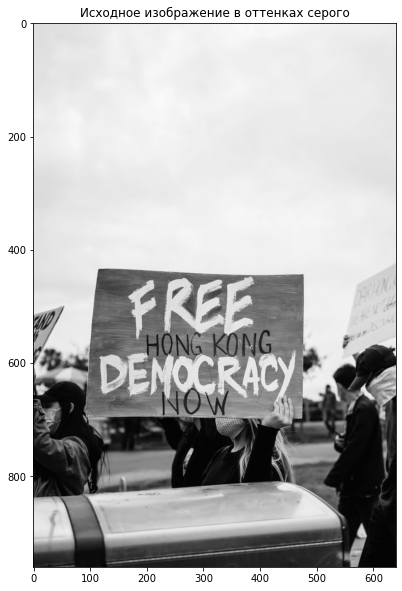

In [45]:
plt.figure(figsize=(10,10))
img = cv.imread(path+ext, 0)
plt.title("Исходное изображение в оттенках серого")
plt.imshow(img, plt.cm.gray)

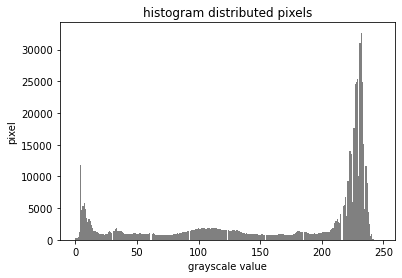

In [46]:
hist(img)

In [47]:
def hist(img:np.ndarray):
    plt.figure()
    plt.hist(img.ravel(), bins=255, color='gray')
    plt.title("histogram distributed pixels")
    plt.xlabel("grayscale value")
    plt.ylabel("pixel")
    plt.show()

In [48]:
@njit(parallel=True)
def gradient(img: np.ndarray, approximate: bool)->np.ndarray:
    x, y = img.shape
    output = np.zeros((x,y), np.uint8)
    for i in prange(1, x):
        for j in prange(1, y):
            s1 = img[i][j]-img[i-1][j]
            s2 = img[i][j]-img[i][j-1]
            if approximate:
                output[i][j]=math.fabs(s1)+math.fabs(s2)
            else:
                output[i][j] = math.hypot(s1,s2)
    return output

def threshold_processing(img: np.ndarray, threshold: np.uint8)->np.ndarray:
    output = np.where(img > threshold, 255, 0)
    return output

In [49]:
img_grad = gradient(img, False)
img_grad_thresh = threshold_processing(img_grad, 30)

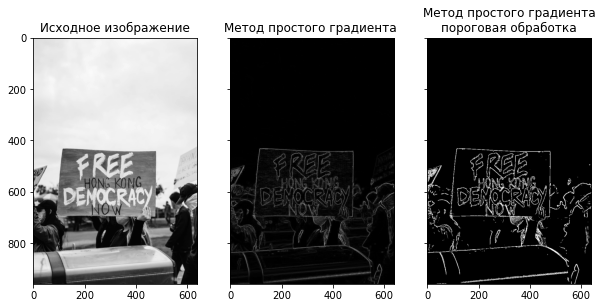

In [50]:
fig, axs = plt.subplots(1,3, figsize=(10,10),sharey=True)
axs[0].set_title("Исходное изображение")
axs[0].imshow(img,cmap=plt.cm.gray)

axs[1].set_title("Метод простого градиента ")
axs[1].imshow(img_grad,cmap=plt.cm.gray)

axs[2].set_title("Метод простого градиента\nпороговая обработка")
axs[2].imshow(img_grad_thresh,cmap=plt.cm.gray)
plt.show()

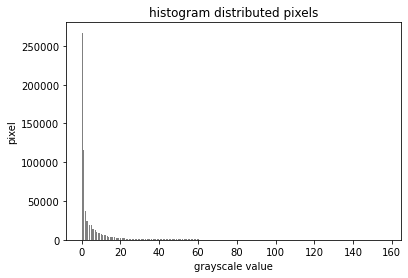

In [51]:
hist(img_grad)

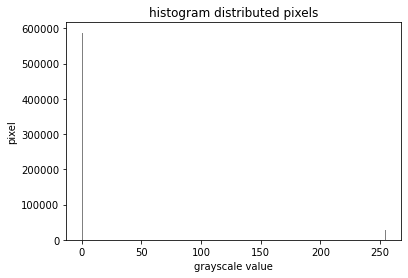

In [52]:
hist(img_grad_thresh)

In [53]:
def convolution2d(image, kernel, stride, padding):
    image = np.pad(image, [(padding, padding), (padding, padding)], mode='constant', constant_values=0)

    kernel_height, kernel_width = kernel.shape
    padded_height, padded_width = image.shape

    output_height = (padded_height - kernel_height) // stride + 1
    output_width = (padded_width - kernel_width) // stride + 1

    new_image = np.zeros((output_height, output_width)).astype(np.float32)

    for y in prange(0, output_height):
        for x in prange(0, output_width):
            new_image[y][x] = np.sum(image[y * stride:y * stride + kernel_height, x * stride:x * stride + kernel_width] * kernel).astype(np.float32)
    return new_image

In [54]:
struct =np.array([[0, 1, 0],[1,-4,1],[0,1,0]])

In [55]:
%%time
img_approximate=threshold_processing(convolution2d(img, struct, 1, 1),25)

CPU times: user 25.1 s, sys: 2.97 ms, total: 25.1 s
Wall time: 25.1 s


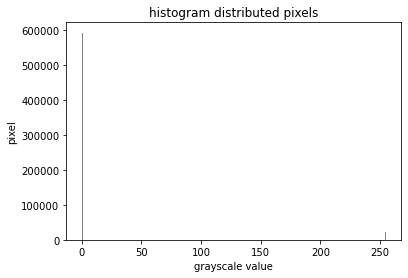

In [56]:
hist(img_approximate)

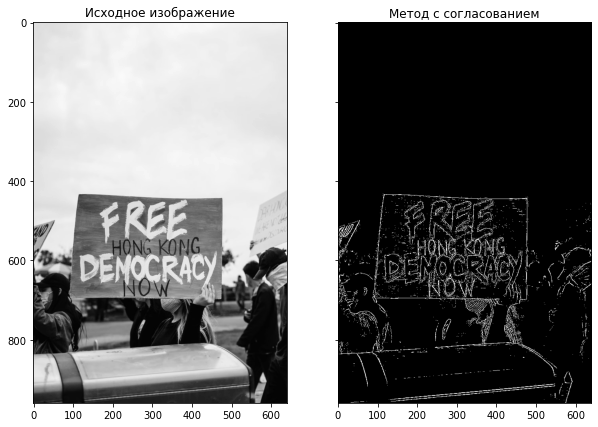

In [57]:
fig, axs = plt.subplots(1,2, figsize=(10,10),sharey=True)
axs[0].set_title("Исходное изображение")
axs[0].imshow(img,cmap=plt.cm.gray)

axs[1].set_title("Метод с согласованием")
axs[1].imshow(img_approximate,cmap=plt.cm.gray)
plt.show()

In [58]:
def conv(window, weighted_window):
    result = []
    h, w = window.shape
    for i in range(h):
      for j in range(w):
        result.append(window[h - i - 1, w - j - 1] * weighted_window[h - i - 1, w - j - 1])
    return np.sum(result)

def sobel(image: np.ndarray, window_s1: np.ndarray, window_s2: np.ndarray):
    h, w = image.shape
    window_h, window_w = (3, 3)
    new_image = np.zeros((h, w), np.uint8)
    for i in range(window_h // 2, h - window_h // 2):
        for j in range(window_w // 2, w - window_w // 2):
            cur_window = image[i - window_h // 2: i + window_h // 2 + 1, j - window_w // 2: j +  window_w // 2 + 1]      
            s1 = conv(cur_window, window_s1)
            s2 = conv(cur_window, window_s2)
            new_image[i][j] = math.hypot(s1, s2)
    return new_image

In [59]:
window_s1 = np.array([[-1, -2, -1], 
                      [0, 0 ,0], 
                      [1, 2, 1]]
                     )
window_s2 = np.array([[-1,0,1], 
                      [-2,0,2], 
                      [-1,0,1]]
                     )

In [60]:
img_sobel = sobel(img, window_s1, window_s2)
img_sobel_thresh = threshold_processing(img_sobel, 25)

KeyboardInterrupt: 

In [ ]:
hist(img_sobel_thresh)

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(10,10),sharey=True)
axs[0].set_title("Исходное изображение")
axs[0].imshow(img,cmap=plt.cm.gray)

axs[1].set_title("Оператор Собеля")
axs[1].imshow(img_sobel,cmap=plt.cm.gray)

axs[2].set_title("Оператор Собеля\nпороговая обработка")
axs[2].imshow(img_sobel_thresh,cmap=plt.cm.gray)
plt.show()